# Custom models — sklearn CV utilities (без ручных циклов)

Этот ноутбук заменяет ручной расчёт по фолдам на стандартные утилиты sklearn:
- `cross_validate` для оценки по фолдам
- `cross_val_predict(method='predict_proba')` для OOF вероятностей

Дальше эти OOF вероятности можно использовать для сравнения моделей и (при желании) ансамблей.


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if (PROJECT_ROOT / "src").exists() is False and (PROJECT_ROOT.parent / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("src exists:", (PROJECT_ROOT / "src").exists())

PROJECT_ROOT: /Users/sergey/code/renthop-lightautoml-vs-custom
src exists: True


In [2]:

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss

from src.config import Paths, TARGET_COL, ID_COL, SEED
from src.models.cv import evaluate_multiclass_cv
from src.models.custom import (
    make_tfidf_logreg_pipeline,
    make_lgbm_ohe_pipeline,
    make_lgbm_targetenc_pipeline,
    make_catboost_model,
    catboost_fit_params,
)
from src.utils.seed import set_global_seed

set_global_seed(SEED)
paths = Paths()

df = pd.read_pickle(paths.data_processed/"model_table.pkl")
spec = json.loads((paths.data_processed / "feature_spec.json").read_text(encoding="utf-8"))

train_df = df[df[TARGET_COL].notna()].copy()
test_df  = df[df[TARGET_COL].isna()].copy()

labels = ["high", "medium", "low"]
print("Train:", train_df.shape, "Test:", test_df.shape)


Train: (49352, 34) Test: (74659, 34)


## 1) TF‑IDF + LogisticRegression (текст + табличные фичи)
Пайплайн полностью sklearn‑совместим, CV делаем через `evaluate_multiclass_cv`.


/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sergey/Library/Python/3.9/li

TFIDF+LR fold logloss: [0.7358738896423462, 0.7446348101593175, 0.7422394979565626]
TFIDF+LR mean logloss: 0.7409160659194088
TFIDF+LR OOF  logloss: 0.7409179670760245


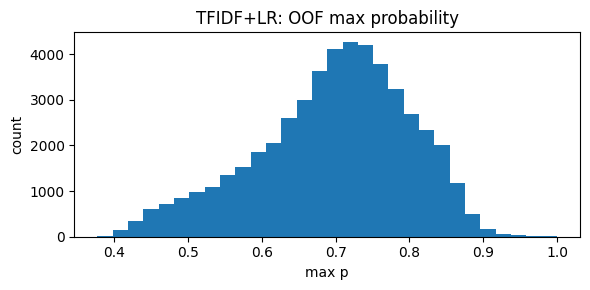

In [3]:

X = train_df[spec["numeric_cols"] + spec["categorical_cols"] + spec["text_cols"]].copy()
y = train_df[TARGET_COL].astype(str).copy()

pipe_tfidf = make_tfidf_logreg_pipeline(
    numeric_cols=spec["numeric_cols"],
    categorical_cols=spec["categorical_cols"],
    text_cols=spec["text_cols"],
    max_features=60000,  
)

res_tfidf = evaluate_multiclass_cv(
    estimator=pipe_tfidf,
    X=X,
    y=y,
    labels=labels,
    n_splits=3,       
    seed=SEED,
    n_jobs=-1,
)
print("TFIDF+LR fold logloss:", res_tfidf.scores)
print("TFIDF+LR mean logloss:", res_tfidf.mean_score)
print("TFIDF+LR OOF  logloss:", log_loss(y, res_tfidf.oof_pred, labels=labels))

plt.figure(figsize=(6,3))
plt.hist(res_tfidf.oof_pred.max(axis=1), bins=30)
plt.title("TFIDF+LR: OOF max probability")
plt.xlabel("max p")
plt.ylabel("count")
plt.tight_layout()
plt.show()


## 2) LGBM + OneHotEncoder


In [ ]:

X_tab = train_df[spec["numeric_cols"] + spec["categorical_cols"]].copy()
y_tab = train_df[TARGET_COL].astype(str).copy()

pipe_lgbm_ohe = make_lgbm_ohe_pipeline(
    numeric_cols=spec["numeric_cols"],
    categorical_cols=spec["categorical_cols"],
    params={"n_estimators": 1200, "learning_rate": 0.05},
)

res_lgbm_ohe = evaluate_multiclass_cv(
    estimator=pipe_lgbm_ohe,
    X=X_tab,
    y=y_tab,
    labels=labels,
    n_splits=3,
    seed=SEED,
    n_jobs=-1,
)
print("LGBM+OHE fold logloss:", res_lgbm_ohe.scores)
print("LGBM+OHE mean logloss:", res_lgbm_ohe.mean_score)
print("LGBM+OHE OOF  logloss:", log_loss(y_tab, res_lgbm_ohe.oof_pred, labels=labels))


/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## 3) LGBM + multiclass target encoding (только табличные)
Target encoding реализован как sklearn‑трансформер, поэтому CV делается стандартно.
Важно: encoder `fit` вызывается только на train‑части каждого фолда (sklearn это обеспечивает).


In [ ]:

pipe_lgbm_te = make_lgbm_targetenc_pipeline(
    numeric_cols=spec["numeric_cols"],
    categorical_cols=spec["categorical_cols"],
    labels=labels,
    params={"n_estimators": 2000, "learning_rate": 0.03},
)

res_lgbm_te = evaluate_multiclass_cv(
    estimator=pipe_lgbm_te,
    X=X_tab,
    y=y_tab,
    labels=labels,
    n_splits=3,
    seed=SEED,
    n_jobs=-1,
)
print("LGBM+TE fold logloss:", res_lgbm_te.scores)
print("LGBM+TE mean logloss:", res_lgbm_te.mean_score)
print("LGBM+TE OOF  logloss:", log_loss(y_tab, res_lgbm_te.oof_pred, labels=labels))


## 4) CatBoost (native категориальные)
CatBoost — sklearn‑совместим, но `cat_features` нужно передать через `fit_params`.


In [ ]:

X_cb = train_df[spec["numeric_cols"] + spec["categorical_cols"]].copy()
y_cb = train_df[TARGET_COL].astype(str).copy()

cb = make_catboost_model(params={"iterations": 800, "learning_rate": 0.08})
fit_params = catboost_fit_params(X_cb, cat_cols=spec["categorical_cols"])

res_cb = evaluate_multiclass_cv(
    estimator=cb,
    X=X_cb,
    y=y_cb,
    labels=labels,
    n_splits=3,
    seed=SEED,
    n_jobs=-1,
    fit_params=fit_params,
)
print("CatBoost fold logloss:", res_cb.scores)
print("CatBoost mean logloss:", res_cb.mean_score)
print("CatBoost OOF  logloss:", log_loss(y_cb, res_cb.oof_pred, labels=labels))


## Сравнение моделей


In [ ]:

summary = pd.DataFrame({
    "model": ["TFIDF+LR", "LGBM+OHE", "LGBM+TE", "CatBoost"],
    "mean_fold_logloss": [res_tfidf.mean_score, res_lgbm_ohe.mean_score, res_lgbm_te.mean_score, res_cb.mean_score],
    "oof_logloss": [
        log_loss(y, res_tfidf.oof_pred, labels=labels),
        log_loss(y_tab, res_lgbm_ohe.oof_pred, labels=labels),
        log_loss(y_tab, res_lgbm_te.oof_pred, labels=labels),
        log_loss(y_cb, res_cb.oof_pred, labels=labels),
    ],
}).sort_values("oof_logloss")

display(summary)
